# PROJECT SUBMISSION BY SUJATHA PATEL

# AllLife Credit Card Customer Segmentation


Background: AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.
Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

Data Description:
 Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

Steps to follow:
1. Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)
2. Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs. (5 marks)
3. Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)
4. Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)
5. Calculate average silhouette score for both methods. (5 marks)
6. Compare K-means clusters with Hierarchical clusters. (5 marks)
7. Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)

<a id='packages'></a>
### Import Packages

In [1]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
#import matplotlib.style as style; style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
%matplotlib inline

#3d_plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

### Customized Functions

In [2]:
# customized function to find the skewness, outliers of all columns
def cdescribe(df):
  results = []
  for col in df.select_dtypes(include = ['float64', 'int64']).columns.tolist():
    stats = OrderedDict({'': col, 
                         'Count': df[col].count(), 
                         'Type': df[col].dtype, 
                         'Mean': round(df[col].mean(), 2), 
                         'StdDev': round(df[col].std(), 2), 
                         'Variance': round(df[col].var(), 2), 
                         'Minimum': round(df[col].min(), 2), 
                         'Q1': round(df[col].quantile(0.25), 2), 
                         'Median': round(df[col].median(), 2), 
                         'Q3': round(df[col].quantile(0.75), 2), 
                         'Maximum': round(df[col].max(), 2),
                         'Range': round(df[col].max(), 2)-round(df[col].min(), 2), 
                         'IQR': round(df[col].quantile(0.75), 2)-round(df[col].quantile(0.25), 2),
                         'Kurtosis': round(df[col].kurt(), 2), 
                         'Skewness': round(df[col].skew(), 2), 
                         'MeanAbsDev': round(df[col].mad(), 2)})
    if df[col].skew() < -1:
      if df[col].median() < df[col].mean(): ske = 'Highly Skewed (Right)'      
      else: ske = 'Highly Skewed (Left)'
    elif -1 <= df[col].skew() <= -0.5:
      if df[col].median() < df[col].mean(): ske = 'Moderately Skewed (Right)'
      else: ske = 'Moderately Skewed (Left)'
    elif -0.5 < df[col].skew() <= 0:  
      if df[col].median() < df[col].mean(): ske = 'Fairly Symmetrical (Right)'
      else: ske = 'Fairly Symmetrical (Left)' 
    elif 0 < df[col].skew() <= 0.5:
      if df[col].median() < df[col].mean(): ske = 'Fairly Symmetrical (Right)'
      else: ske = 'Fairly Symmetrical (Left)'
    elif 0.5 < df[col].skew() <= 1:
      if df[col].median() < df[col].mean(): ske = 'Moderately Skewed (Right)'
      else: ske = 'Moderately Skewed (Left)'
    elif df[col].skew() > 1:
      if df[col].median() < df[col].mean(): ske = 'Highly Skewed (Right)'
      else: ske = 'Highly Skewed (Left)'
    else:
      ske = 'Error'
    stats['SkewnessComment'] = ske
    upper_lim, lower_lim = stats['Q3'] + (1.5 * stats['IQR']), stats['Q1'] - (1.5 * stats['IQR'])
    if len([x for x in df[col] if x < lower_lim or x > upper_lim])>1:
      out = 'HasOutliers'
    else:
      out = 'NoOutliers'
    stats['OutliersComment'] = out
    results.append(stats)
    if df[col].median() > df[col].mean():
       med_mean = "more than"
    elif df[col].median() < df[col].mean():
       med_mean = "less than"
    else:
       med_mean = "same as"

    # Printi the descriptive statistics report for all the columns in concrete dataset
    print(f'\n{col} - Data ranges between {round(df[col].min(),2)} to {round(df[col].max(),2)}, while 25th and 75th percentile is spread between {round(df[col].quantile(0.25),2)} to {round(df[col].quantile(0.75),2)}. Median {round(df[col].median(),2)} is {med_mean} than Mean {round(df[col].mean(),2)} which means cement is {ske}. Column has {out}.')
  
  describe = pd.DataFrame(results).set_index('')
              
  return display(describe.T)
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

# function for ploting distribution of variables with target
def target_plot(df, col1, col2, col3, target = 'class'):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    f.suptitle(f'Distribution for Car, Bus, Van for {col1.capitalize()}, {col2.capitalize()}, {col3.capitalize()}', 
               fontsize = 14)
    # Distribution for col1 considering outliers
    sns.distplot(df[(df[target] == 3)][col1], color = 'c', ax = ax1, hist = False, 
                 label = 'Car').set_title(f'{col1.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col1], color = 'b', ax = ax1, hist = False, 
                 label = 'Bus').set_title(f'{col1.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col1], color = 'm', ax = ax1, hist = False, 
                 label = 'Van').set_title(f'{col1.capitalize()}')

    # Distribution for col2 considering outliers
    sns.distplot(df[(df[target] == 3)][col2], color = 'c', ax = ax2, hist = False, 
                 label = 'Car').set_title(f'{col2.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col2], color = 'b', ax = ax2, hist = False, 
                 label = 'Bus').set_title(f'{col2.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col2], color = 'm', ax = ax2, hist = False, 
                 label = 'Van').set_title(f'{col2.capitalize()}')

    # Distribution for col3 considering outliers
    sns.distplot(df[(df[target] == 3)][col3], color = 'c', ax = ax3, hist = False, 
                 label = 'Car').set_title(f'{col3.capitalize()}')
    sns.distplot(df[(df[target] == 2)][col3], color = 'b', ax = ax3, hist = False, 
                 label = 'Bus').set_title(f'{col3.capitalize()}')
    sns.distplot(df[(df[target] == 1)][col3], color = 'm', ax = ax3, hist = False, 
                 label = 'Van').set_title(f'{col3.capitalize()}')
    return plt.show()

# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])

# Helper function for PCA plots
def pca_plots(df, col1, col2, xlabel, ylabel, ax):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.set_title(f'{xlabel} vs {ylabel}', fontsize = 14)
    targets = [3, 2, 1]; colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indicesToKeep = df['class'] == target
        ax.scatter(df.loc[indicesToKeep, col1], df.loc[indicesToKeep, col2], c = color, s = 50)
    ax.legend(targets)

# Helper function to plot learning curve
def plot_learning_curve(estimator, X, y,  ax, ylim = None, cv = None, n_jobs = 1,
                        train_sizes = np.linspace(.1, 1.0, 5), name = 'Naive Bayes \n Principal Compoents Learning Curve'):    
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, 
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                     alpha = 0.1, color = '#ff9124')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                     alpha = 0.1, color = '#2492ff')

    ax.plot(train_sizes, train_scores_mean, 'o-', color = '#ff9124', label = 'Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color ='#2492ff', label = 'Cross-validation score')
    ax.set_title(name, fontsize = 14)
    ax.set_xlabel('Training size')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc = 'best')
    
# Outliers removal
def replace_outliers(df, col, method = 'quantile', strategy = 'median', drop = True):
    if method == 'quantile':
        Q3, Q2, Q1 = df[col].quantile([0.75, 0.50, 0.25])
        IQR = Q3 - Q1
        upper_lim = Q3 + (1.5 * IQR)
        lower_lim = Q1 - (1.5 * IQR)
        #print(f'Outliers for {col} are: {sorted([x for x in df[col] if x < lower_lim or x > upper_lim])}\n')
        if strategy == 'median':
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = Q2
        else:
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = df[col].mean()
    elif method == 'log':
        df[col] = np.log(df[col])
    else:
      print('Please pass the correct method, strategy or drop criteria')
    
    
def set_kmeans(df1, df2, df3, k):
    model=KMeans(k)
    model.fit(df3)
    prediction=model.predict(df3)

    #Append the prediction 
    df1["cust_seg_group"] = prediction
    df2["cust_seg_group"] = prediction
    df3["cust_seg_group"] = prediction
    print("Groups : \n")
    df1.head()
    

## 3D plots for clusters
def td_plot(df):
    fig = plt.figure(figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 4],c=prediction.astype(np.float), edgecolor='k')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Length')
    ax.set_ylabel('Height')
    ax.set_zlabel('Weight')
    ax.set_title('3D plot of KMeans Clustering')
    
## Drop cust_sec_group
def drop_cust_seg(df1, df2, df3):
    df1.drop("cust_seg_group",axis=1,inplace=True)
    df2.drop("cust_seg_group",axis=1,inplace=True)
    df3.drop("cust_seg_group",axis=1,inplace=True)
     

### Exploratory Data Analysis

<a id='reading'></a>
### Reading the data as a dataframe and print the first five rows

In [3]:
# Reading the data as dataframe and print the first five rows
ccc = pd.read_excel('Credit_Card_Customer_Data.xlsx')
ccc.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
# columns provides the columns in the dataset
ccc.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

<a id='info'></a>
### Get info of the data types and dataframe columns 

In [5]:
# Get info of the dataframe columns
ccc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
### Get the shpe (rows and columns)
ccc.shape

(660, 7)

In [7]:
# Checking any null values in dataframe
ccc.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<a id='o1'></a>
Observation: Dataset has 660 rows and 7 columns with NO NULL values in any columns.

In [8]:
# Remove duplicate rows (not removing the duplicates) /* There is no duplicates*/
ccc1=ccc.copy()
print('Number of rows before discarding duplicates = %d' % (ccc1.shape[0]))
ccc1.drop_duplicates(subset = None, keep = 'first', inplace=True)
print('Number of rows after discarding duplicates = %d' % (ccc1.shape[0]))

Number of rows before discarding duplicates = 660
Number of rows after discarding duplicates = 660


In [9]:
# Drop the Sl_no and Customer_key columns
ccc1.drop('Sl_No',axis=1,inplace=True)
ccc1.drop('Customer Key',axis=1,inplace=True)
ccc1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<a id='5point'></a>
### Five point summary of numerical attributes

In [10]:
# Five point summary
ccc1.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


<a id='o2'></a>
Observation 
<br> Sl_No and Customer Key will be dropped off
<br> The Avg_Credit_Limit has very high Std dev. The values are higher for 75% and Max range
<br> The Total_visits_online and Total_calls_made columns have higher values in Max range
<br> The Total_visits_bank , Total_visits_online and Total_call_made columns have 0 values for the Min range

Let us do the customized descriptive statistical analysis of all numerical values

### Descriptive statistics for the numerical variables

In [11]:
cdescribe(ccc1)


Avg_Credit_Limit - Data ranges between 3000 to 200000, while 25th and 75th percentile is spread between 10000.0 to 48000.0. Median 18000.0 is less than than Mean 34574.24 which means cement is Highly Skewed (Right). Column has HasOutliers.

Total_Credit_Cards - Data ranges between 1 to 10, while 25th and 75th percentile is spread between 3.0 to 6.0. Median 5.0 is more than than Mean 4.71 which means cement is Fairly Symmetrical (Left). Column has NoOutliers.

Total_visits_bank - Data ranges between 0 to 5, while 25th and 75th percentile is spread between 1.0 to 4.0. Median 2.0 is less than than Mean 2.4 which means cement is Fairly Symmetrical (Right). Column has NoOutliers.

Total_visits_online - Data ranges between 0 to 15, while 25th and 75th percentile is spread between 1.0 to 4.0. Median 2.0 is less than than Mean 2.61 which means cement is Highly Skewed (Right). Column has HasOutliers.

Total_calls_made - Data ranges between 0 to 10, while 25th and 75th percentile is spread betw

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Count,660,660,660,660,660
Type,int64,int64,int64,int64,int64
Mean,34574.2,4.71,2.4,2.61,3.58
StdDev,37625.5,2.17,1.63,2.94,2.87
Variance,1.41568e+09,4.7,2.66,8.62,8.21
Minimum,3000,1,0,0,0
Q1,10000,3,1,1,1
Median,18000,5,2,2,3
Q3,48000,6,4,4,5
Maximum,200000,10,5,15,10


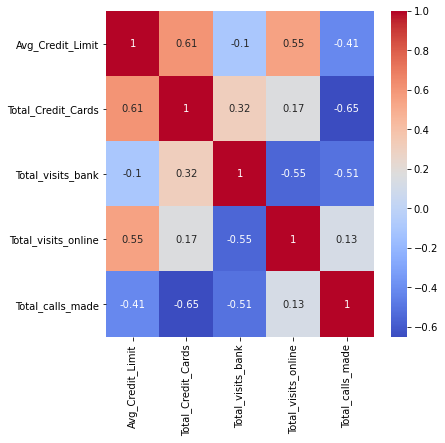

In [12]:
plt.figure(figsize = (6, 6))
sns.heatmap(ccc1.corr(), annot=True, cmap='coolwarm', 
            xticklabels=ccc1.columns,
            yticklabels=ccc1.columns)

In [13]:
# scaling of the data 
cccScaled=ccc1.apply(zscore)
cccScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<a id='unibi'></a>
### Univariate Visualization

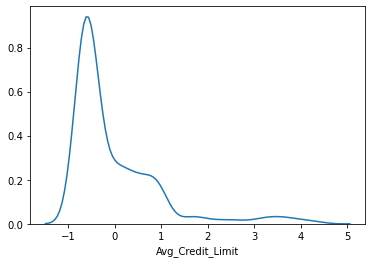


 Avg_Credit_Limit has atleast 3 clusters


In [14]:
# Univariate Analysis of columns
sns.distplot(cccScaled['Avg_Credit_Limit'],hist=False,)
plt.show()
print("\n Avg_Credit_Limit has atleast 3 clusters")

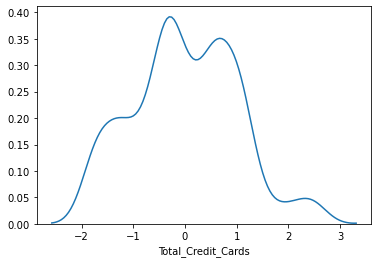


 Total_Credit_Cards has atleast 3 to 4 clusters


In [15]:
sns.distplot(cccScaled['Total_Credit_Cards'],hist=False,)
plt.show()
print("\n Total_Credit_Cards has atleast 3 to 4 clusters")

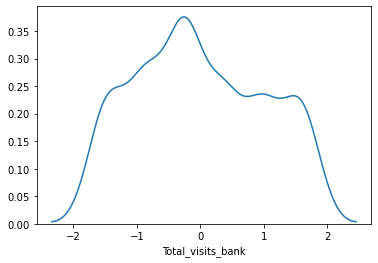


 Total_visits_bank has atleast 4 to 5 clusters


In [16]:
# Univariate Analysis of columns
sns.distplot(cccScaled['Total_visits_bank'],hist=False,)
plt.show()
print("\n Total_visits_bank has atleast 4 to 5 clusters")

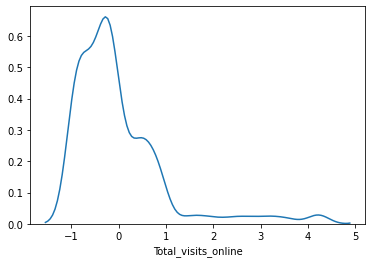


 Total_visits_bank has atleast 4 to 5 clusters


In [17]:
# Univariate Analysis of columns
sns.distplot(cccScaled['Total_visits_online'],hist=False,)
plt.show()
print("\n Total_visits_bank has atleast 4 to 5 clusters")

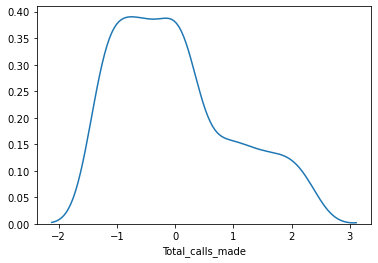


 Total_calls_made has atleast 3 to 4 clusters


In [18]:
sns.distplot(cccScaled['Total_calls_made'],hist=False,)
plt.show()
print("\n Total_calls_made has atleast 3 to 4 clusters")

### Based on the above information we can work with 3 to 4 clusters


### Bi-variate Visulaization

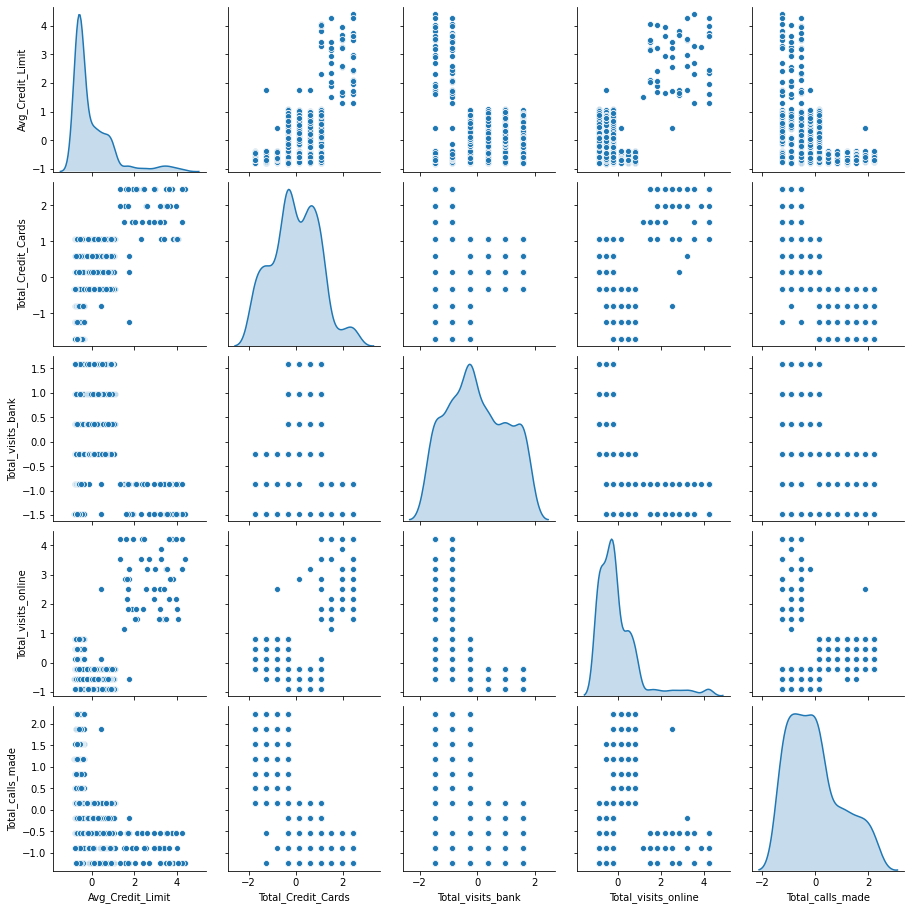

In [19]:
sns.pairplot(cccScaled,diag_kind='kde')

<br> a) Avg_Credit_Limit increases , Total_credit cards and Total_visit_online increases. But Total_calls_made decreases
<br> b) Total_calls_made and Total_visits_bank decreases as Average credit limit increases
<br> c) Total_visits_online decreases with increase with Total_calls_made
<br> d) Total_visits_online increases with decrease of Total_visits_bank

### K-Means Clustering - Elbow

Text(0.5, 1.0, 'Elbow Method - Selection of K')

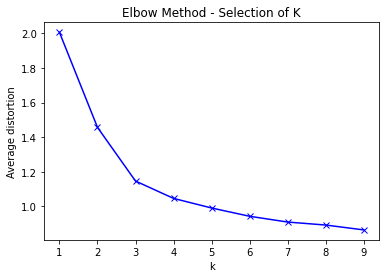

In [20]:
#Finding optimal no. of clusters
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(cccScaled)
    prediction=model.predict(cccScaled)
    meanDistortions.append(sum(np.min(cdist(cccScaled, model.cluster_centers_, 'euclidean'), axis=1)) / cccScaled
                           .shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Elbow Method - Selection of K')

### We will look at clusters where k=3, k=4 and k=5

### K Means (K=3)

In [126]:
# Let us first start with K = 3
cccScaled=ccc1.apply(zscore)
drop_cust_seg(ccc, ccc1, cccScaled)

# Let us first start with K = 3
final_model=KMeans(3)
final_model.fit(cccScaled)
prediction=final_model.predict(cccScaled)

#Append the prediction 
ccc["cust_seg_group"] = prediction
ccc1["cust_seg_group"] = prediction
cccScaled["cust_seg_group"] = prediction

print("Groups Assigned : \n")
ccc.head()

Groups Assigned : 



,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,1


In [127]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12174.107143,2.410714,0.933036,3.553571,6.870536


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189A96E148>,
      dtype=object)

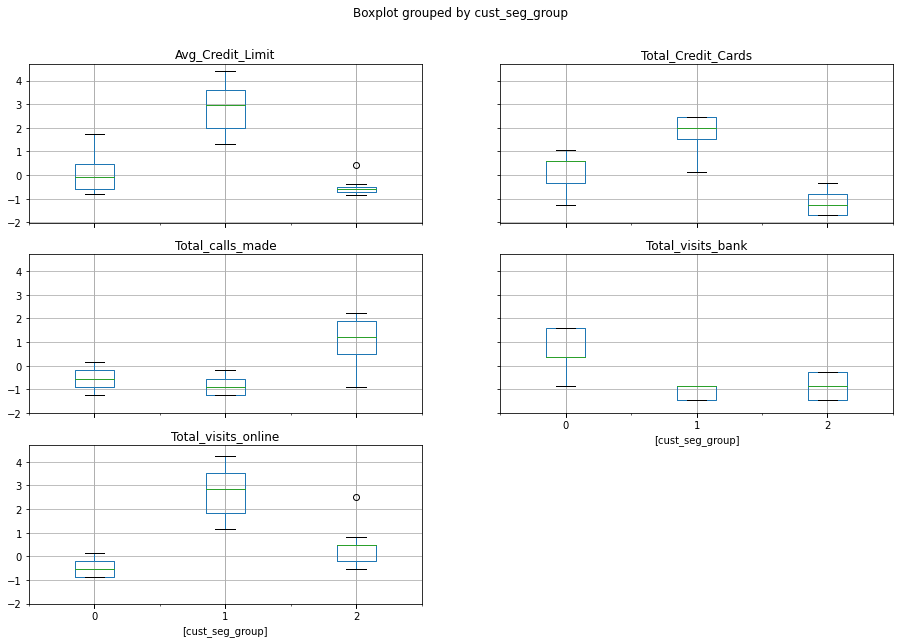

In [128]:
cccScaled.boxplot(by='cust_seg_group', layout = (3,2),figsize=(15,10))

From the above box plot all the groups are different . 
<br>We can group the customer segment as Basic, Standard and Premium customers.
<br>BASIC Customers : Average credit limit around 12K and with average of 2 to 3 credit cards . These customers have high interaction calls with bank and followed by medium visits online.
<br>STANDARD Customers : Average credit limit around 33K and with average of 5 to 6 credit cards . These customers have high interaction through bank visits followed by calls to bank
<br>PREMIUM Customers : Average credit limit around 141K and with average of 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank

In [129]:
# Silhoutte Avg Score
sc_result = pd.DataFrame({'Method' : ['K-Means'], 'Clusters' : ['3'],
                      'silhouette_score' : [silhouette_score(cccScaled,prediction)]})
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863


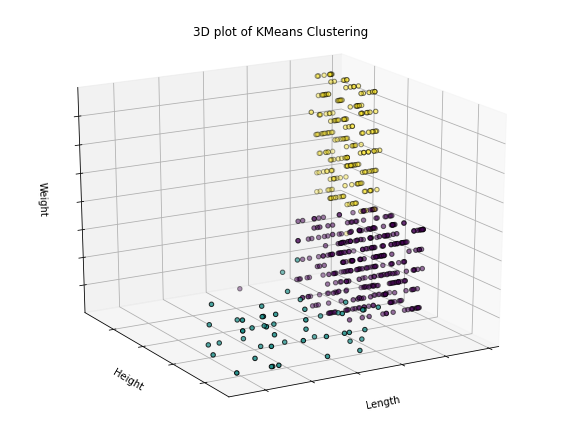

In [130]:
td_plot(cccScaled)

### K Means (K=4)

In [131]:
drop_cust_seg(ccc, ccc1, cccScaled)
# Let us set k=4
set_kmeans(ccc, ccc1, cccScaled, 4)
ccc.head()

Groups : 



,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,1,87073,100000,2,1,1,0,1
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,1
3,4,40496,30000,5,1,1,4,1
4,5,47437,100000,6,0,12,3,0


In [132]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000
1,35904.522613,5.522613,2.477387,0.969849,2.075377
2,12167.420814,2.393665,0.927602,3.574661,6.923077
3,31226.315789,5.478947,4.515789,1.010526,1.936842


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189B0080C8>,
      dtype=object)

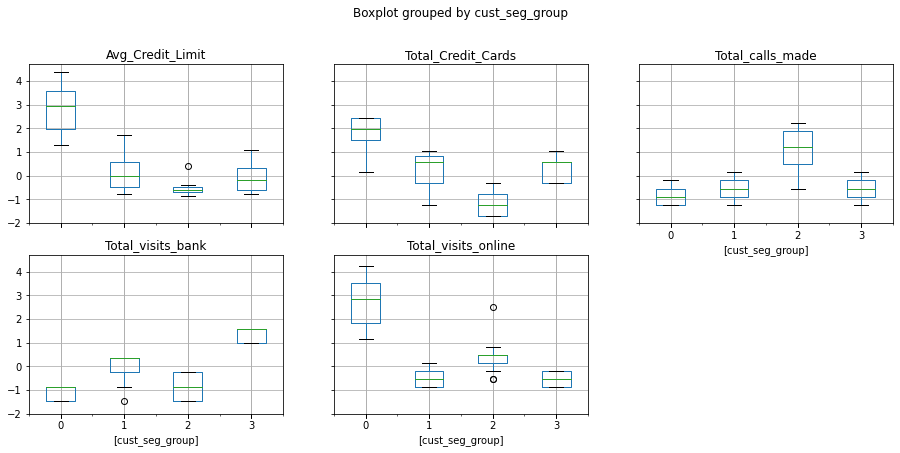

In [133]:
cccScaled.boxplot(by='cust_seg_group', layout = (3,3),figsize=(15,10))

<br> There is not much difference for Basic and Premium Customers
<br> The standard Customers differs slightly on total_calls_made, total_visits_online and total_visits_bank

In [134]:
sc_result.loc[1] = ['K-Means','4',silhouette_score(cccScaled,prediction)]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634


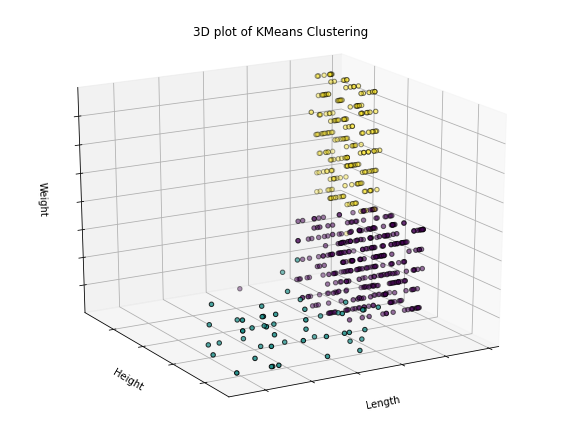

In [135]:
td_plot(cccScaled)

### K Means (K=5)

In [136]:
drop_cust_seg(ccc, ccc1, cccScaled)
# Let us set K - 5
set_kmeans(ccc, ccc1, cccScaled, 5)
ccc.head()

Groups : 



,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,1,87073,100000,2,1,1,0,2
1,2,38414,50000,3,0,10,9,4
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,2
4,5,47437,100000,6,0,12,3,0


In [137]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000
1,12019.801980,2.475248,1.000000,3.465347,5.009901
2,36260.204082,5.551020,2.494898,0.954082,2.061224
3,31226.315789,5.478947,4.515789,1.010526,1.936842
4,12300.813008,2.357724,0.878049,3.626016,8.398374


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189B858EC8>,
      dtype=object)

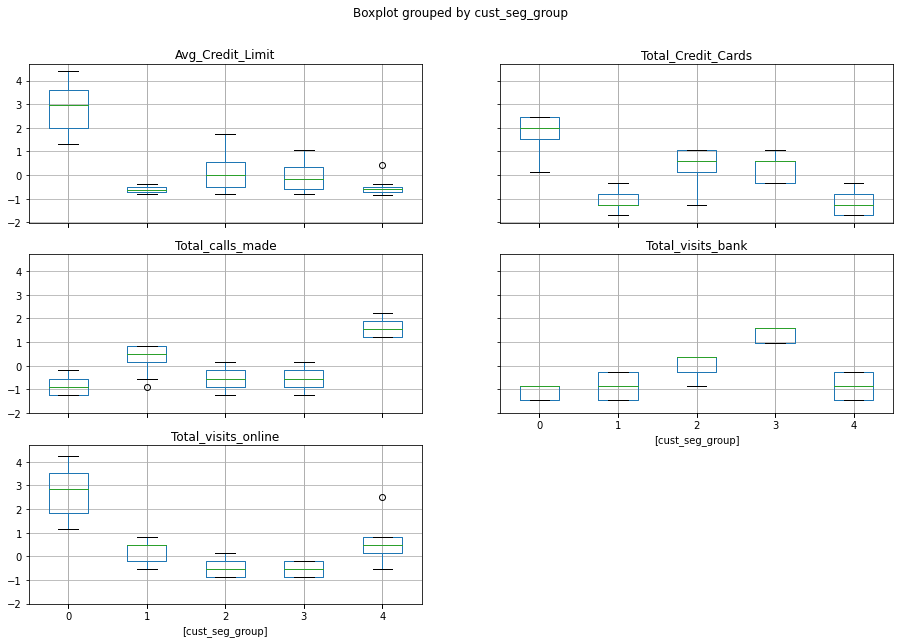

In [138]:
cccScaled.boxplot(by='cust_seg_group', layout = (3,2),figsize=(15,10))

<br> There is not much difference in STANDARD Customers
<br> PREMIUM Customers differ on total visits to bank
<br> BASIC Customers differ on total Calls made to bank

In [139]:
sc_result.loc[2] = ['K-Means','5',silhouette_score(cccScaled,prediction)]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075


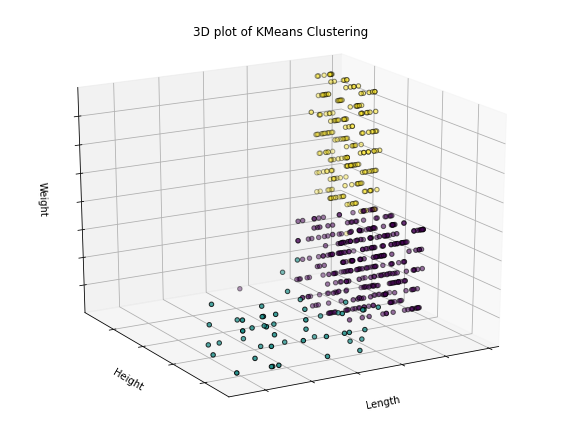

In [140]:
td_plot(cccScaled)

For the above , we can consider K-Means with Cluster = 3 , as the other clusters are varied only 
based on the single customer interactions for each group like Standard Customers on Bank visits and 
Basic Customers on total calls made.

### Hierarchical (Single) - Dendogram

In [141]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

In [142]:
Z = linkage(cccScaled, metric='euclidean', method='single')
c, coph_dists = cophenet(Z , pdist(cccScaled))
result = pd.DataFrame({'Linkage_Method' : ['single'], 'Linkage_Metric' : ['eucliden'],
                      'Cophenet_distance' : [c]})
result

,Linkage_Method,Linkage_Metric,Cophenet_distance
0,single,eucliden,0.880232


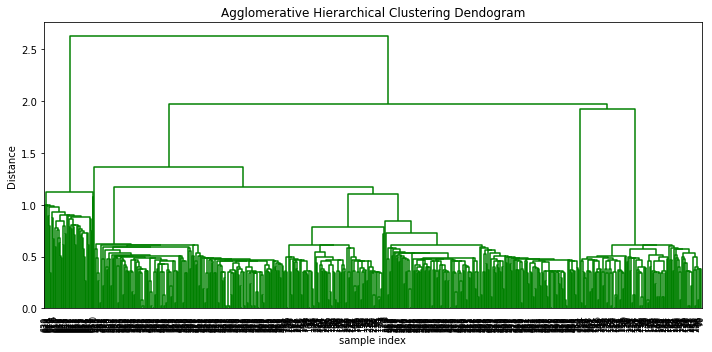

In [143]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

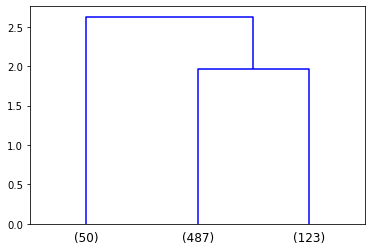

In [144]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

In [145]:
from sklearn.cluster import AgglomerativeClustering

### Hierarchical (Single, K=3)

In [146]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [147]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='single')

In [148]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='single', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [149]:
ccc["cust_seg_group"] = model.labels_
ccc1["cust_seg_group"] = model.labels_
cccScaled['cust_seg_group'] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [150]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,25807.881773,4.377668,2.555008,1.912972,3.779967
1,50000.000000,3.000000,0.000000,10.000000,9.000000
2,141040.000000,8.740000,0.600000,10.900000,1.080000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189D8A6A88>,
      dtype=object)

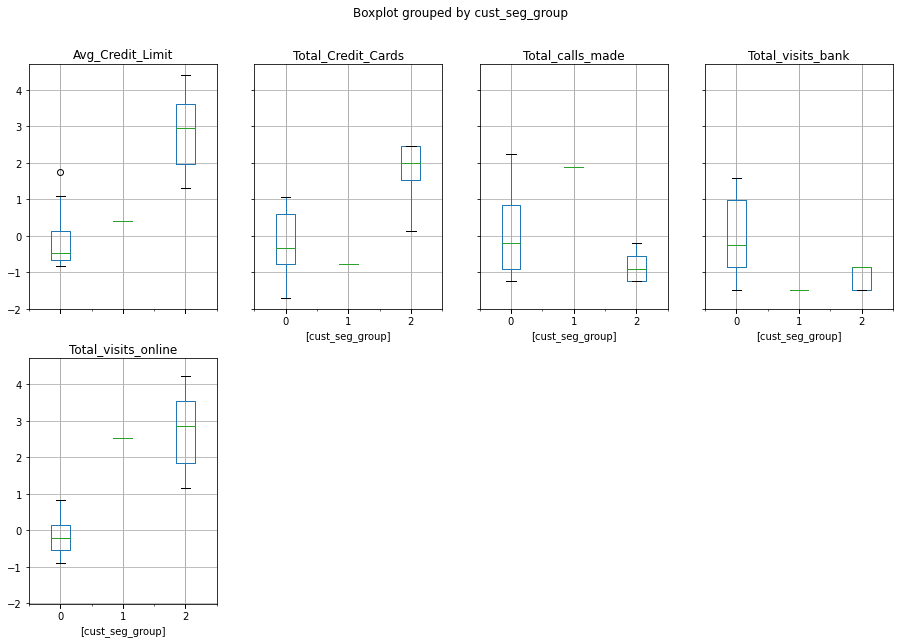

In [151]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

BASIC Customers : Average credit limit around 25K and with average of 4 to 5 credit cards . These customers have high interaction through calls to bank followed by visits to bank.
<br> STANDARD Customers : Average credit limit around 50K and with average of 3 credit cards . These customers have high interaction through bank visits followed by calls to bank
<br> PREMIUM Customers : Average credit limit around 141K and with average of 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank

In [152]:
sc_result.loc[3] = ['Hier-Clusteriing(single)','3',silhouette_score(cccScaled,model.labels_)]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086


Hierarchical Clustering(Single) score is lowest of all

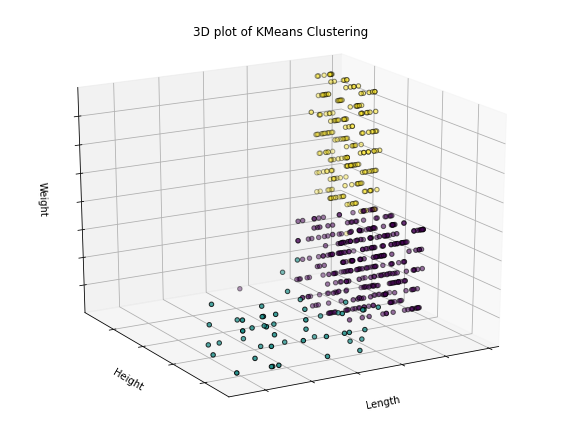

In [153]:
td_plot(cccScaled)

In [154]:
cccScaled['cust_seg_group'].value_counts()

0    609
2     50
1      1
Name: cust_seg_group, dtype: int64

Looks like cluster 1 has only one record

### Hierarchical (Single, K=4)

In [155]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [156]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='single')

In [157]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='single', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [158]:
ccc["cust_seg_group"] = model.labels_
ccc1["cust_seg_group"] = model.labels_
cccScaled['cust_seg_group'] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,3
1,50000,3,0,10,9,1
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
4,100000,6,0,12,3,0
5,20000,3,0,1,8,2
6,100000,5,0,11,2,0
7,15000,3,0,1,1,2
8,5000,2,0,2,2,2
9,3000,4,0,1,7,2


In [159]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000
1,50000.000000,3.000000,0.000000,10.000000,9.000000
2,25685.855263,4.381579,2.557566,1.914474,3.786184
3,100000.000000,2.000000,1.000000,1.000000,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189DC732C8>,
      dtype=object)

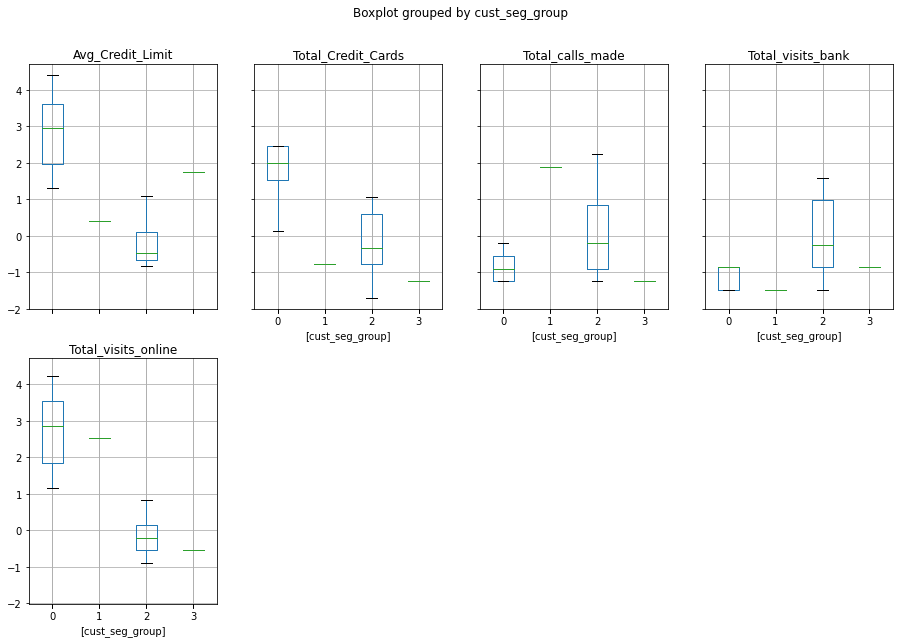

In [160]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

In [161]:
sc_result.loc[4] = ['Hier-Clusteriing(single)','4',silhouette_score(cccScaled,model.labels_)]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954


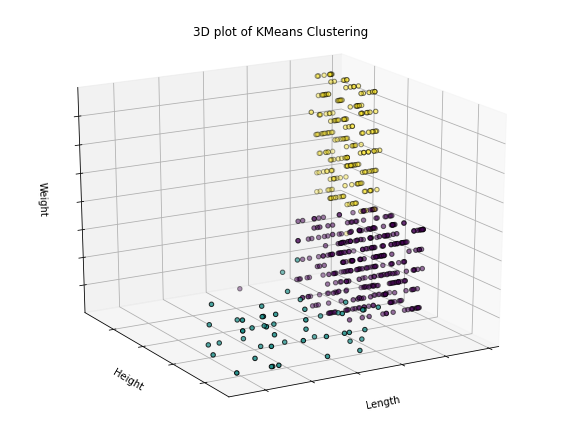

In [162]:
td_plot(cccScaled)

The silhouette score is not very good . We will cehck the next linkage

### Hierarchical (Complete) - Dendogram

In [163]:
Z = linkage(cccScaled, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(cccScaled))
result.loc[1] = ['complete','eculidean',c]
result

,Linkage_Method,Linkage_Metric,Cophenet_distance
0,single,eucliden,0.880232
1,complete,eculidean,0.868622


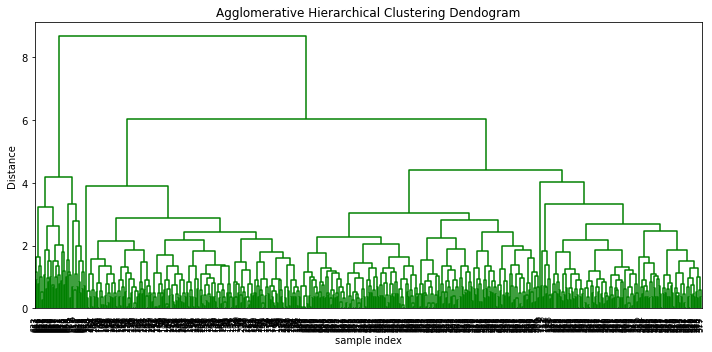

In [164]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

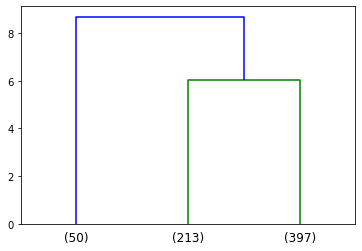

In [165]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

### Hierarchical (Complete, K=3)

In [166]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [167]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')

In [168]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=3, pooling_func='deprecated')

In [169]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled["cust_seg_group"] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,2


In [170]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,33151.133501,5.460957,3.405542,1.010076,2.060453
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12234.741784,2.352113,0.957746,3.633803,7.009390


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189F6B0788>,
      dtype=object)

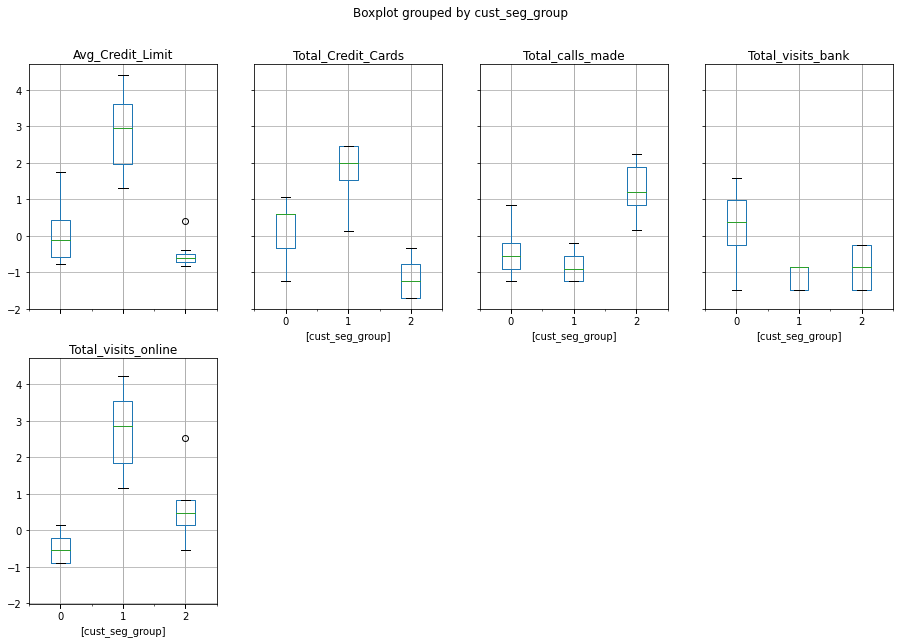

In [171]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

BASIC Customers : Average credit limit around 12K and average of 2 to 3 credit cards . These customers have high interaction through calls to bank followed by online visits.
<br>STANDARD Customers : Average credit limit around 33K and average of 5 credit cards . These customers have high interaction through bank visits followed by calls to bank
<br>PREMIUM Customers : Average credit limit around 141K and averageof 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank

In [172]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[5] = ['Hier-Clusteriing(complete)','3',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268


Silhouette_score looks for K-Means / Cluster 3 better than others

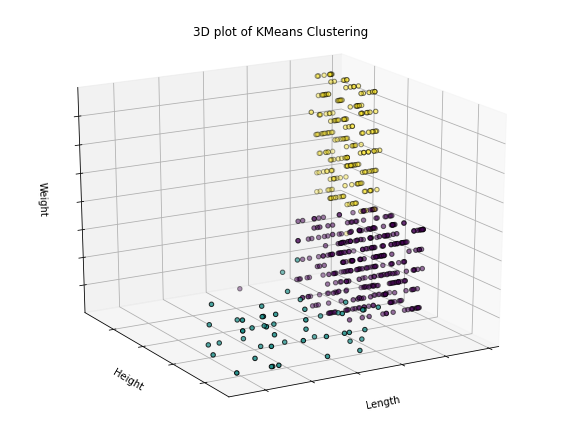

In [173]:
td_plot(cccScaled)

### Hierarchical (Single, K=4)

In [174]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [175]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='complete')

In [176]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=4, pooling_func='deprecated')

In [177]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled["cust_seg_group"] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,1
1,50000,3,0,10,9,2
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,0
5,20000,3,0,1,8,2
6,100000,5,0,11,2,0
7,15000,3,0,1,1,1
8,5000,2,0,2,2,1
9,3000,4,0,1,7,2


In [178]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000
1,29331.250000,5.350000,2.318750,1.006250,2.550000
2,12234.741784,2.352113,0.957746,3.633803,7.009390
3,35729.957806,5.535865,4.139241,1.012658,1.729958


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189D7C4A08>,
      dtype=object)

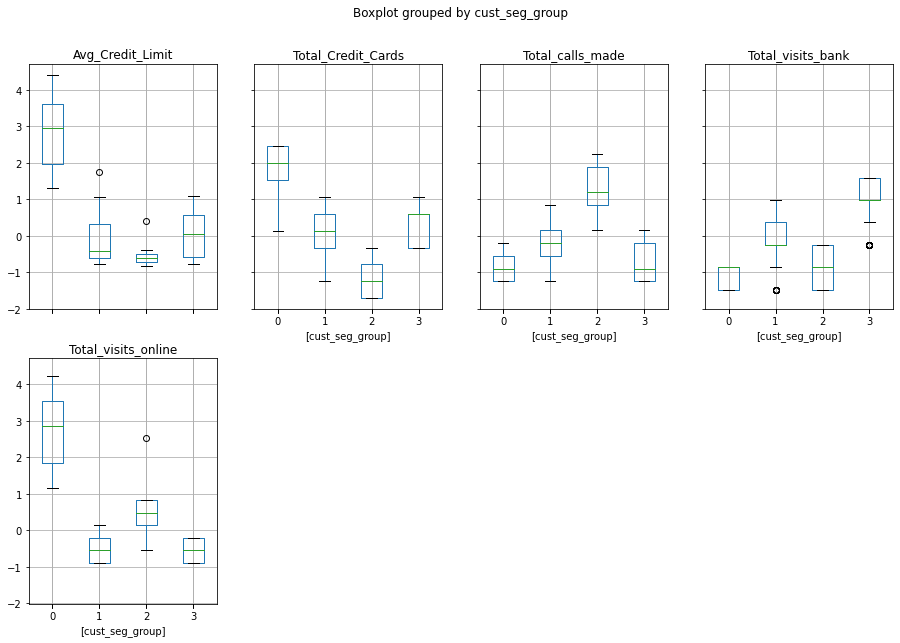

In [179]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

when we run with Cluster K=4 ,
There is not much difference for Basic and Standard Value Customers
The Premium Customers differ on total visits to bank

In [180]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[6] = ['Hier-Clusteriing(complete)','4',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268
6,Hier-Clusteriing(complete),4,0.479338


Silhouette Score is less than score of cluster = 3

### Hierarchical (Average) - Dendogram

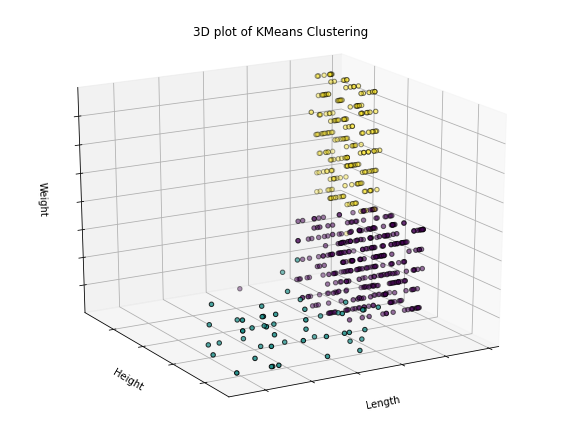

In [181]:
td_plot(cccScaled)

In [182]:
Z = linkage(cccScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(cccScaled))
result.loc[2] = ['average','eculidean',c]
result

,Linkage_Method,Linkage_Metric,Cophenet_distance
0,single,eucliden,0.880232
1,complete,eculidean,0.868622
2,average,eculidean,0.909812


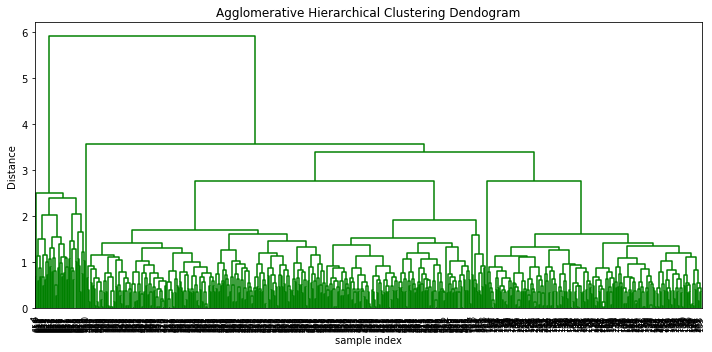

In [183]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

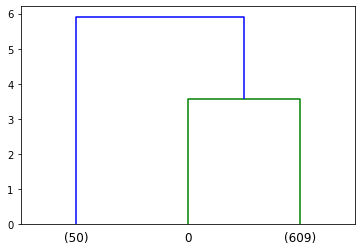

In [184]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

### Hierarchical (Average, K=3)

In [185]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [186]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')

In [187]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=3, pooling_func='deprecated')

In [188]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled["cust_seg_group"] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1
5,20000,3,0,1,8,2
6,100000,5,0,11,2,1
7,15000,3,0,1,1,2
8,5000,2,0,2,2,2
9,3000,4,0,1,7,2


In [189]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189E00F388>,
      dtype=object)

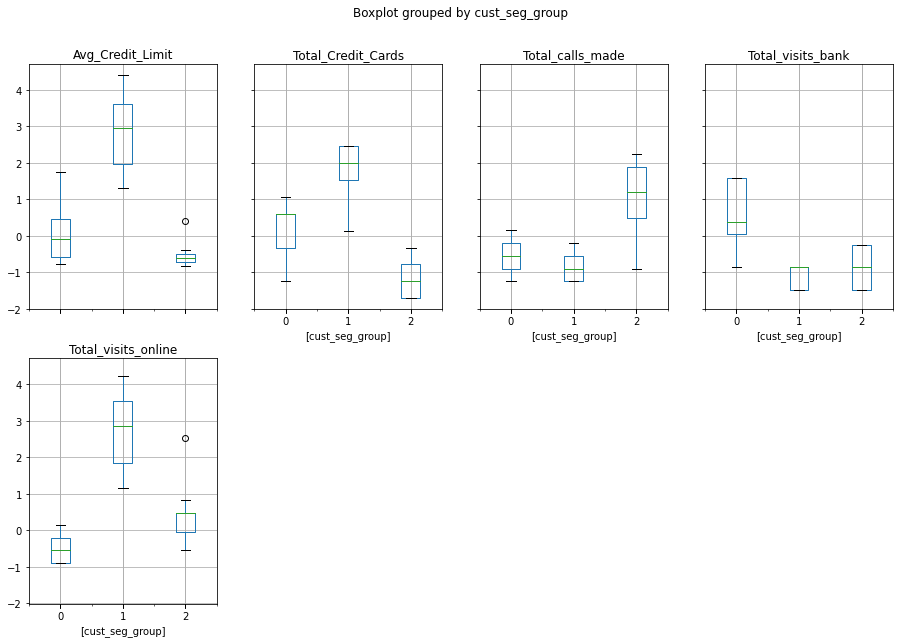

In [190]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

BASIC Customers : Average credit limit around 12K and average of 2 credit cards . These customers have high interaction through calls to bank followed by online visits.
<br>STANDARD Customers : Average credit limit around 33K and avergae of 5 to 6 credit cards . These customers have high interaction through bank visits followed by calls to bank
<br>PREMIUM Customers : Average credit limit around 141K and avergae of 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank¶

In [191]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[7] = ['Hier-Clusteriing(average)','3',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268
6,Hier-Clusteriing(complete),4,0.479338
7,Hier-Clusteriing(average),3,0.590990


Silhouette Score fo K-means / cluster 3 is better compared to others

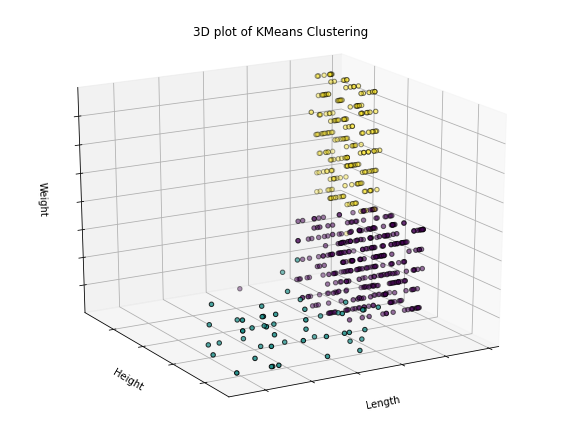

In [192]:
td_plot(cccScaled)

### Hierarchical (Average, K=4)

In [193]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [194]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')

In [195]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=4, pooling_func='deprecated')

In [196]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled['cust_seg_group'] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,3
1,50000,3,0,10,9,0
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
4,100000,6,0,12,3,1
5,20000,3,0,1,8,0
6,100000,5,0,11,2,1
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [197]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000118A209F588>,
      dtype=object)

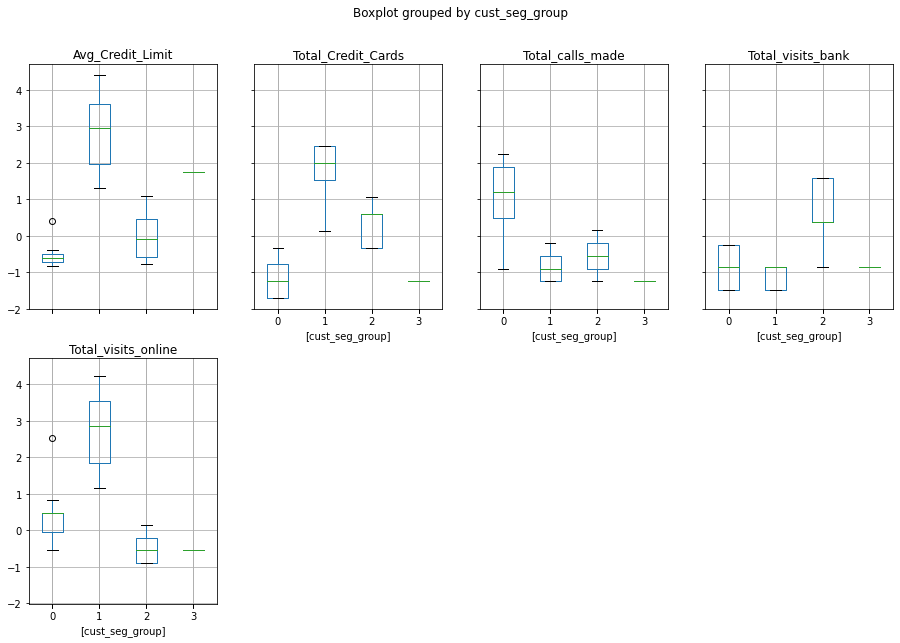

In [198]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

Looks like there is one record for one of the clusters

In [199]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[8] = ['Hier-Clusteriing(average)','4',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268
6,Hier-Clusteriing(complete),4,0.479338
7,Hier-Clusteriing(average),3,0.590990
8,Hier-Clusteriing(average),4,0.537601


In [200]:
cccScaled['cust_seg_group'].value_counts()

2    386
0    223
1     50
3      1
Name: cust_seg_group, dtype: int64

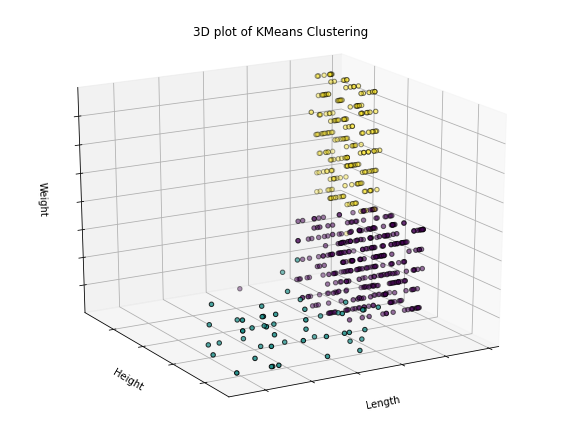

In [201]:
td_plot(cccScaled)

### Hierarchical (Ward) - Dendogram

In [202]:
Z = linkage(cccScaled, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(cccScaled))
result.loc[3] = ['ward','eculidean',c]
result

,Linkage_Method,Linkage_Metric,Cophenet_distance
0,single,eucliden,0.880232
1,complete,eculidean,0.868622
2,average,eculidean,0.909812
3,ward,eculidean,0.816876


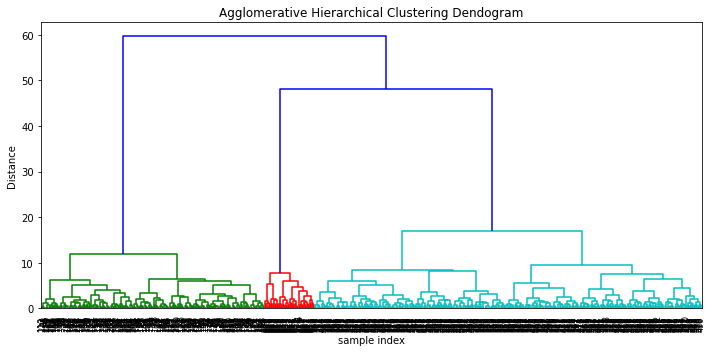

In [203]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

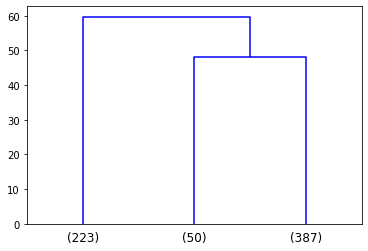

In [204]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

### Hierarchical (Ward, K=3)

In [206]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [207]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')

In [208]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [209]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled['cust_seg_group'] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2
5,20000,3,0,1,8,1
6,100000,5,0,11,2,2
7,15000,3,0,1,1,1
8,5000,2,0,2,2,1
9,3000,4,0,1,7,1


In [210]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805
1,12151.111111,2.422222,0.937778,3.546667,6.857778
2,141040.000000,8.740000,0.600000,10.900000,1.080000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001189F58AC88>,
      dtype=object)

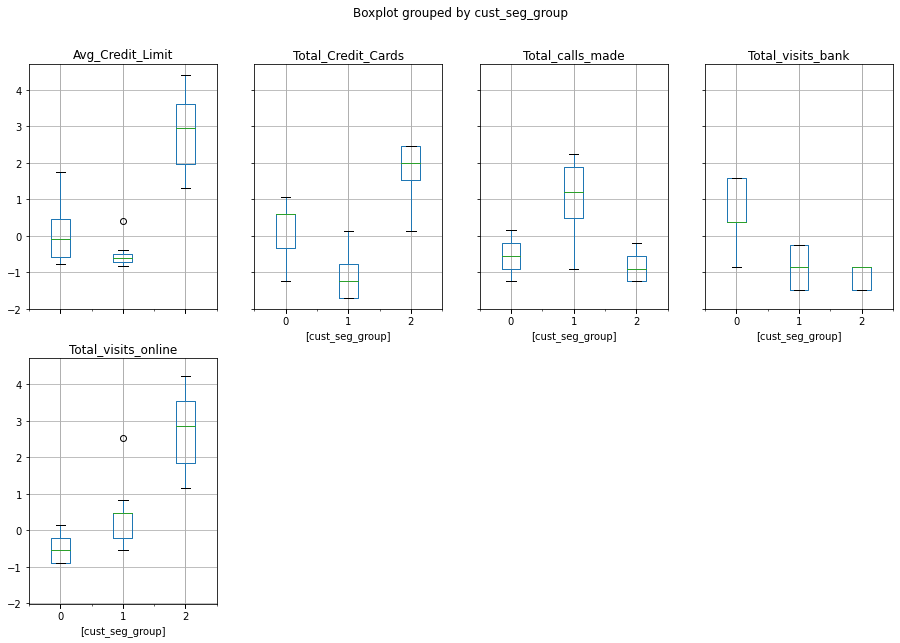

In [211]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

BASIC Customers : Average credit limit around 12K and average of 2 credit cards . These customers have high interaction through calls to bank followed by online visits.
<br>STANDARD Customers : Average credit limit around 33K and average of 5 to 6 credit cards . These customers have high interaction through bank visits followed by calls to bank
<br>PREMIUM Customers : Average credit limit around 141K and average of 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank

In [212]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[9] = ['Hier-Clusteriing(ward)','3',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268
6,Hier-Clusteriing(complete),4,0.479338
7,Hier-Clusteriing(average),3,0.590990
8,Hier-Clusteriing(average),4,0.537601
9,Hier-Clusteriing(ward),3,0.540316


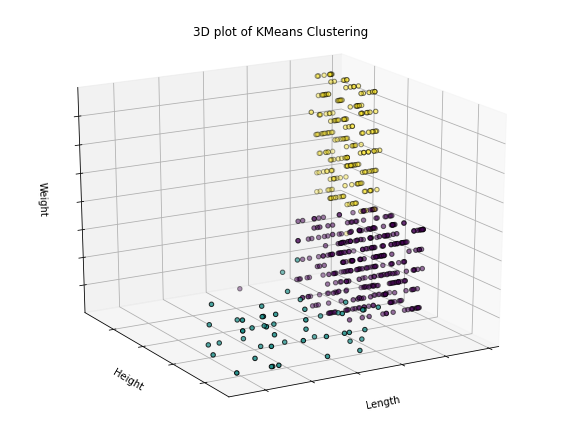

In [213]:
td_plot(cccScaled)

### Hierarchical (Ward, K=4)

In [214]:
drop_cust_seg(ccc, ccc1, cccScaled)

In [215]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='ward')

In [216]:
model.fit(cccScaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [217]:
ccc['cust_seg_group'] = model.labels_
ccc1['cust_seg_group'] = model.labels_
cccScaled['cust_seg_group'] = model.labels_
ccc1.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cust_seg_group
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [218]:
ccc1.groupby(['cust_seg_group']).mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cust_seg_group,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778
1,38298.429319,5.670157,2.523560,0.947644,2.099476
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,29474.226804,5.365979,4.448454,1.010309,1.891753


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000118A28B3D88>,
      dtype=object)

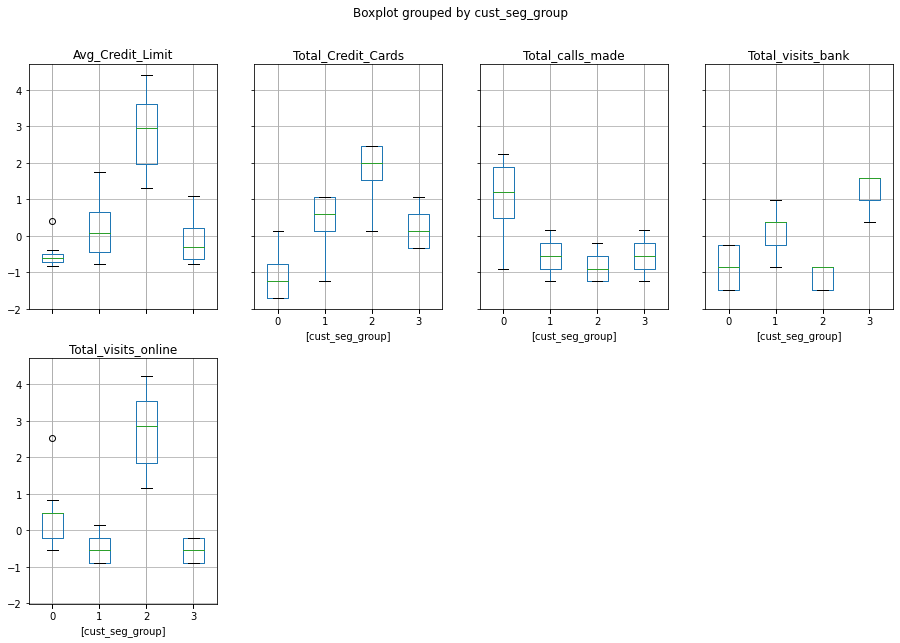

In [219]:
cccScaled.boxplot(by='cust_seg_group', layout = (2,4),figsize=(15,10))

In [220]:
There is not much difference for Basic and Standard Customers
The Premium Customers differ on total visits to bank

SyntaxError: invalid syntax (<ipython-input-220-fb077fa2e981>, line 1)

In [221]:
sc_av=silhouette_score(cccScaled,model.labels_)
sc_result.loc[10] = ['Hier-Clusteriing(ward)','4',sc_av]
sc_result

,Method,Clusters,silhouette_score
0,K-Means,3,0.590863
1,K-Means,4,0.462634
2,K-Means,5,0.462075
3,Hier-Clusteriing(single),3,0.401086
4,Hier-Clusteriing(single),4,0.256954
5,Hier-Clusteriing(complete),3,0.581268
6,Hier-Clusteriing(complete),4,0.479338
7,Hier-Clusteriing(average),3,0.590990
8,Hier-Clusteriing(average),4,0.537601
9,Hier-Clusteriing(ward),3,0.540316


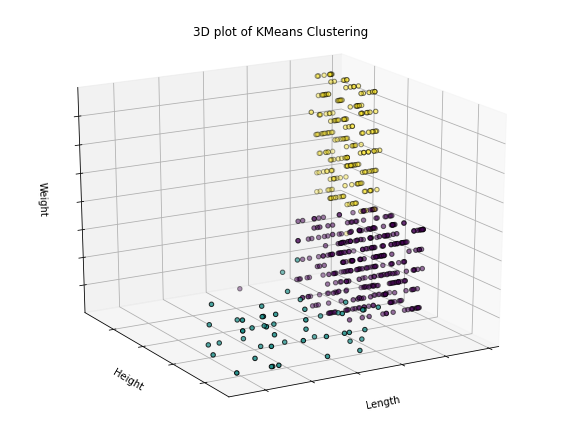

In [222]:
td_plot(cccScaled)

<b>Hierarchical clustering we can go with linkage metric complete or Average with 3 clusters 

<br>overall the silhouette score is betwwen 40 and 60

<br>for the K-means cluster =3 it is .59 and for hierarchical clustering(average) cluster =3 is .59 

<br>From the above 3D graphs , the K-Means and hierarchical clustering the clusters are nearly the same for Clusters =3

<br>How many different segments of customers are there?
<br>We can group the customer segment into 3 as Basic, Standard and Premium customers.

<br>How are these segments different from each other?
<br>BASIC Customers : Average credit limit around 12K and average of 2 to 3 credit cards . These customers have high interaction through calls to bank followed by online visits.
<br>STANDARD Customers : Average credit limit around 30K and average of 5 to 6 credit cards . These customers have high interaction through bank visits followed by calls to bank 
<br>PREMIUM Customers : Average credit limit around 140K and average of 8 to 9 credit cards . These customers have high interaction through online visits followed by calls to bank

<br>What are your recommendations to the bank on how to better market to and service these customers?
<br>The services for the STANDARD customers needs to analyzed ,so that the customers does not stop  using the bank's product or service during a certain time frame
<br>The servies for the PREMIUM and BASIC customers needs to be analyzed and campaigns can be targeted for upsell</b>

# END OF PROJECT